# Testing Uniform Coditioning (using true data anamorphosis)

This script is a test of uniform conditioning using the true data. We use a grid with 1x1 unit spacing containing known values in point support. The data is reblocked into 2x2 units SMUs (selective mining units) and 10x10 panels. The true grades in SMUs were used to predict the panel grade (Primary), tonnage (True T (c)), and metal (True Q (c))at different cutoffs c.

The panel tonnage and metal was calculated with uniform conditioning (Predicted T (c), and Predicted Q ({})) using the anamorphosis calculated with true grade in point support and then corrected to SMU and panel support.


In [1]:
#general imports
import pygslib    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

## Get data and true grid

In [2]:
#get the data in gslib format into a pandas Dataframe. However, this data is not used in this test. 
clusterdata= pygslib.gslib.read_gslib_file('../data/cluster.dat') 
clusterdata['Zlocation'] = 0. 
clusterdata.head()

,Xlocation,Ylocation,Primary,Secondary,Declustering Weight,Zlocation
0,39.5,18.5,0.06,0.22,1.619,0.0
1,5.5,1.5,0.06,0.27,1.619,0.0
2,38.5,5.5,0.08,0.40,1.416,0.0
3,20.5,1.5,0.09,0.39,1.821,0.0
4,27.5,14.5,0.09,0.24,1.349,0.0


In [3]:
# get exaustive data (this is the data used in this test)
grid = pygslib.gslib.read_gslib_file('../data/true.dat')
grid = pygslib.gslib.addcoord(nx = 50, ny = 50, nz = 1, xmn = 0.5, ymn = 0.5, 
                              zmn = 0.5, xsiz = 1, ysiz = 1, zsiz =1, grid= grid)
grid = grid.rename(columns={"x": "XC", "y": "YC", "z": "ZC"})
grid

,XC,YC,ZC,Primary,Secondary
0,0.5,0.5,0.5,2.26,3.26
1,1.5,0.5,0.5,3.28,2.64
2,2.5,0.5,0.5,2.80,2.15
3,3.5,0.5,0.5,0.95,1.69
4,4.5,0.5,0.5,0.12,0.51
...,...,...,...,...,...
2495,45.5,49.5,0.5,7.11,8.82
2496,46.5,49.5,0.5,9.26,7.97
2497,47.5,49.5,0.5,1.86,8.62
2498,48.5,49.5,0.5,1.12,6.59


<AxesSubplot:>

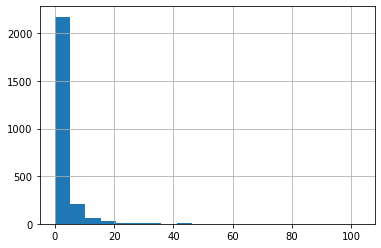

In [4]:
grid['Primary'].hist(bins = 20)

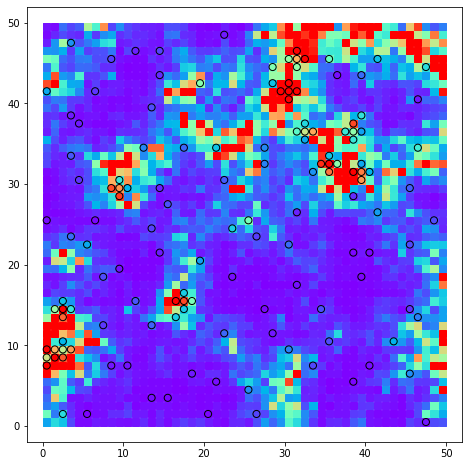

In [5]:
#plot the data using matplotlib
plt.figure(figsize = (8,8))
plt.scatter(grid['XC'],grid['YC'], c= grid['Primary'], s= 50, marker="s",vmin=0, vmax=10,cmap = 'rainbow', alpha=1)
plt.scatter(clusterdata['Xlocation'],clusterdata['Ylocation'], c= clusterdata['Primary'], 
            s= 50, marker="o",vmin=0, vmax=10,cmap = 'rainbow', alpha=1, edgecolors='k')
plt.axis('scaled')
plt.show()

In [6]:
# create a block model in point support
bmodel_point = pygslib.blockmodel.Blockmodel(nx = 50, ny = 50, nz = 1, xorg = 0, yorg = 0, 
                                       zorg = 0, dx = 1, dy = 1, dz =1)
bmodel_point.set_blocks(grid)
bmodel_point.calc_ixyz_fromxyz()
bmodel_point.calc_ijk()

In [7]:
# reblock to smu and panel to get true grade in block and grade tonnage and metal in panel support
dx_smu = 2
dx_panel = dx_smu * 5

#reblock point to get smu data
bmodel_smu = bmodel_point.reblock(nx = 50/dx_smu, ny= 50/dx_smu, nz = 1 , xorg = 0, yorg = 0, 
                     zorg = 0, dx = dx_smu, dy = dx_smu, dz = 1)[0]

# create working indicator, tonnage and metal (relative to panels total tonnage)
zc = np.array([0., 1, 2, 3, 4, 5, 6, 7, 8, 9,  10, 15, 20, 30, 40, 60])
for c in zc:
    bmodel_smu.bmtable['I ({})'.format(c)] = (bmodel_smu.bmtable['Primary']>=c).values.astype(int)
    bmodel_smu.bmtable['True T ({})'.format(c)] = (bmodel_smu.bmtable['Primary']>=c).values.astype(int) * (dx_smu**2/dx_panel**2)
    bmodel_smu.bmtable['True Q ({})'.format(c)] = bmodel_smu.bmtable['True T ({})'.format(c)] * bmodel_smu.bmtable['Primary']

# reblock smu to get average grade, metal and tonnage (reblock produces average, sumation and count of each non system variable)
bmodel_panel = bmodel_smu.reblock(nx = 50/dx_panel, ny= 50/dx_panel, nz = 1 , xorg = 0, yorg = 0, 
                     zorg = 0, dx = dx_panel, dy = dx_panel, dz = 1)[0]


# delete non usefull variables, mainly generated by reblocking function
bmodel_smu.bmtable.drop(['NBLK', 'RD', 'Primary_sum', 'Primary_count', 'Secondary', 'Secondary_sum', 'Secondary_count'], axis=1, inplace = True)
for c in zc:
    bmodel_smu.bmtable.drop('True T ({})'.format(c), axis=1, inplace = True) 
    bmodel_smu.bmtable.drop('True Q ({})'.format(c), axis=1, inplace = True) 
    
# delete non usefull variables, mainly generated by reblocking function
bmodel_panel.bmtable.drop(['NBLK', 'RD', 'Primary_sum', 'Primary_count',
       'Primary_sum_sum', 'Primary_sum_count', 'Primary_count_sum',
       'Primary_count_count', 'Secondary', 'Secondary_sum', 'Secondary_count',
       'Secondary_sum_sum', 'Secondary_sum_count', 'Secondary_count_sum',
       'Secondary_count_count',], axis=1, inplace = True)

for c in zc:
    # more cleaning 
    bmodel_panel.bmtable.drop('True T ({})'.format(c), axis=1, inplace = True) 
    bmodel_panel.bmtable.drop('True Q ({})'.format(c), axis=1, inplace = True) 
    
    # rename tonnage
    bmodel_panel.bmtable['True T ({})'.format(c)] = bmodel_panel.bmtable['True T ({})_sum'.format(c)]
    bmodel_panel.bmtable['True Q ({})'.format(c)] = bmodel_panel.bmtable['True Q ({})_sum'.format(c)]
    
    # more cleaning 
    bmodel_panel.bmtable.drop('True T ({})_sum'.format(c), axis=1, inplace = True) 
    bmodel_panel.bmtable.drop('True Q ({})_sum'.format(c), axis=1, inplace = True) 
    bmodel_panel.bmtable.drop('True T ({})_count'.format(c), axis=1, inplace = True) 
    bmodel_panel.bmtable.drop('True Q ({})_count'.format(c), axis=1, inplace = True)
    bmodel_panel.bmtable.drop('I ({})_sum'.format(c), axis=1, inplace = True)
    bmodel_panel.bmtable.drop('I ({})_count'.format(c), axis=1, inplace = True)

C:\Users\ADRIAN~1.MAR\AppData\Local\Temp/ipykernel_4192/81751582.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bmodel_panel = bmodel_smu.reblock(nx = 50/dx_panel, ny= 50/dx_panel, nz = 1 , xorg = 0, yorg = 0,


In [8]:
bmodel_smu.bmtable.head()

,IJK,Primary,IX,IY,IZ,XC,YC,ZC,I (0.0),I (1.0),...,I (6.0),I (7.0),I (8.0),I (9.0),I (10.0),I (15.0),I (20.0),I (30.0),I (40.0),I (60.0)
0,0,2.9575,0,0,0,1.0,1.0,0.5,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1.9350,1,0,0,3.0,1.0,0.5,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,0.1200,2,0,0,5.0,1.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0.2275,3,0,0,7.0,1.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0.4075,4,0,0,9.0,1.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
bmodel_panel.bmtable.head()

,IJK,Primary,I (0.0),I (1.0),I (2.0),I (3.0),I (4.0),I (5.0),I (6.0),I (7.0),...,True T (15.0),True Q (15.0),True T (20.0),True Q (20.0),True T (30.0),True Q (30.0),True T (40.0),True Q (40.0),True T (60.0),True Q (60.0)
0,0,3.5257,1.0,0.64,0.44,0.32,0.24,0.16,0.16,0.16,...,0.04,0.8476,0.04,0.8476,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.2815,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.2992,1.0,0.52,0.16,0.08,0.04,0.00,0.00,0.00,...,0.00,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.3589,1.0,0.40,0.20,0.20,0.16,0.08,0.04,0.00,...,0.00,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.8067,1.0,0.52,0.28,0.16,0.16,0.08,0.04,0.04,...,0.00,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


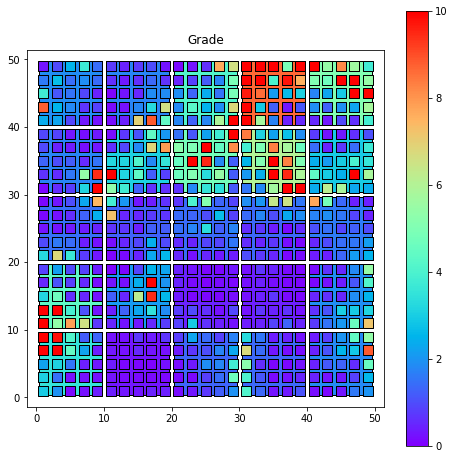

In [10]:
# plot the grade using matplotlib
plt.figure(figsize = (8,8))

plt.scatter(bmodel_panel.bmtable['XC'],bmodel_panel.bmtable['YC'], 
            c= bmodel_panel.bmtable['Primary'], 
            marker="s", cmap = 'rainbow', alpha=1, s = 4000, edgecolors='k', vmin=0, vmax=10)

plt.scatter(bmodel_smu.bmtable['XC'],bmodel_smu.bmtable['YC'], 
            c= bmodel_smu.bmtable['Primary'], 
            marker="s", cmap = 'rainbow', alpha=1, s = 100, edgecolors='k', vmin=0, vmax=10)
plt.axis('scaled')
plt.colorbar()
plt.title("Grade")
plt.show()

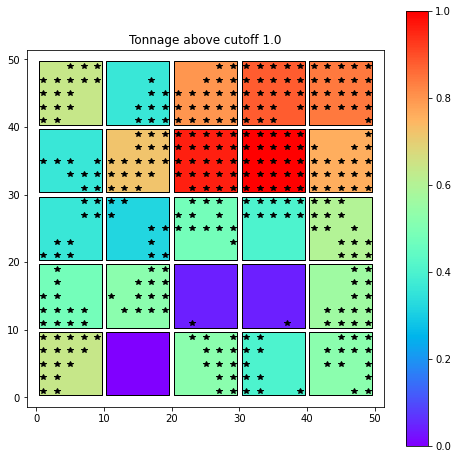

In [11]:
# Plot the panel tonnage an metal and the smu above cutoff c
plt.figure(figsize = (8,8))

c = 1.0
plt.scatter(bmodel_panel.bmtable['XC'],bmodel_panel.bmtable['YC'], 
            c= bmodel_panel.bmtable['True T ({})'.format(c)], 
            marker="s", cmap = 'rainbow', alpha=1, s = 4000, edgecolors='k', vmin=0, vmax=1)

mask = bmodel_smu.bmtable['I ({})'.format(c)]>0
plt.plot(bmodel_smu.bmtable.loc[mask,'XC'],bmodel_smu.bmtable.loc[mask,'YC'], '*k')


plt.axis('scaled')
plt.colorbar()
plt.title("Tonnage above cutoff {}".format(c))
plt.show()

## Interactive anamorphosis modeling on cluster data

('Raw Variance', 22.08676848118367)
('Variance from PCI', 20.35059930508229)
('zamin', 0.21096965147100422)
('zamax', 50.01666229781394)
('yamin', -0.967633525284082)
('yamax', 2.9453773810449038)
('zpmin', 0.06004880303574711)
('zpmax', 58.209448542250705)
('ypmin', -2.1114367132879397)
('ypmax', 2.9453773810449038)


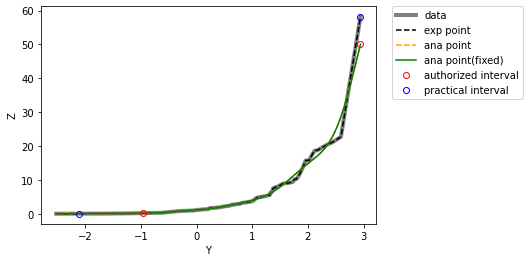

In [12]:
# Fit anamorphosis on cluster
PCI_cluster, H_cluster, raw_cluster, zana_cluster, gauss_cluster, z_cluster, P_cluster, \
raw_var_cluster, PCI_var_cluster, fig1_cluster, \
zamin_cluster, zamax_cluster, yamin_cluster, yamax_cluster, \
zpmin_cluster, zpmax_cluster, ypmin_cluster, ypmax_cluster = pygslib.nonlinear.anamor(
                         z = clusterdata['Primary'], 
                         w = clusterdata['Declustering Weight'], 
                         zmin = None, 
                         zmax = None,
                         zpmin = None, 
                         zpmax = None,
                         ymin= None, 
                         ymax=None,
                         ndisc = 5000,
                         ltail=1, utail=1, ltpar=1, utpar=1, K=39)

('Raw Variance', 26.531797841583963)
('Variance from PCI', 26.045407016924695)
('zamin', 0.11560370246739365)
('zamax', 90.97968167289834)
('yamin', -1.3490417686122065)
('yamax', 3.5386675683754305)
('zpmin', 0.01005300786099545)
('zpmax', 102.49131685775154)
('ypmin', -3.0896951372467485)
('ypmax', 3.5386675683754305)


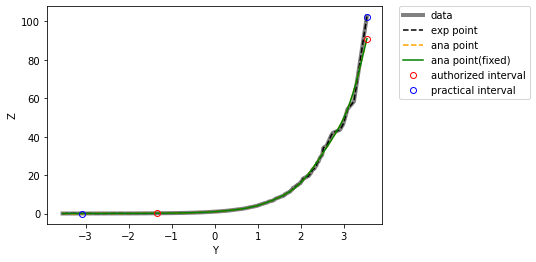

In [13]:
# Fit anamorphosis on grid, just to see difference with point data
PCI_grid, H_grid, raw_grid, zana_grid, gauss_grid, z_grid, P_grid, \
raw_var_grid, PCI_var_grid, fig1_grid, \
zamin_grid, zamax_grid, yamin_grid, yamax_grid, \
zpmin_grid, zpmax_grid, ypmin_grid, ypmax_grid = pygslib.nonlinear.anamor(
                         z = grid['Primary'], 
                         w = np.ones((grid.shape[0],)), 
                         zmin = None, 
                         zmax = None,
                         zpmin = None, 
                         zpmax = None,
                         ymin= None, 
                         ymax=None,
                         ndisc = 5000,
                         ltail=1, utail=1, ltpar=1, utpar=1, K=39)

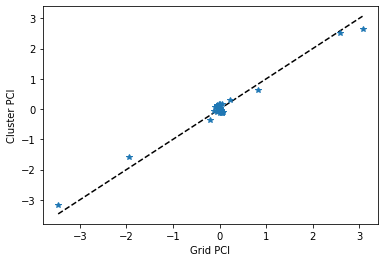

In [14]:
# compare the PCI of the two anamorphosis versions
xxmin = min(PCI_grid.min(), PCI_cluster.min())
xxmax = max(PCI_grid.max(), PCI_cluster.max())
plt.plot([xxmin,xxmax],[xxmin,xxmax], '--k')
plt.xlabel('Grid PCI')
plt.ylabel('Cluster PCI')
plt.plot(PCI_grid, PCI_cluster, '*')
plt.show()

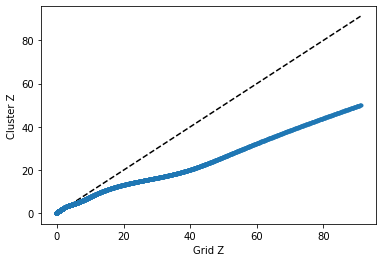

In [15]:
# compare the two anamorphosis
xxmin = min(zana_grid.min(), zana_cluster.min())
xxmax = max(zana_grid.max(), zana_cluster.max())
plt.plot([xxmin,xxmax],[xxmin,xxmax], '--k')
plt.xlabel('Grid Z')
plt.ylabel('Cluster Z')
plt.plot(zana_grid, zana_cluster, '.')
plt.show()

## Uniform conditioning

Using a variogram and the anamorphosis fitted using grid data. 

In [16]:
variogram = {
        # Variogram parameters
        # ----------
        'c0'         :  2.7,   # float, nugget value
        'it'         : [1],   # array('i'), structures type, on for each structure: 1 Spherical, 2 Exponential, 3 Gaussian, 4 Power, 5 Cosine hole effect
        'cc'         : [23.62],   # array('f'), structures variance, one for each structure
        'aa'         : [10],   # array('f'), structures range/practical range in direction 1, one for each structure
        'aa1'        : [10],   # array('f'), structures range/practical range in direction 2, one for each structure
        'aa2'        : [10],   # array('f'), structures range/practical range in direction 3, one for each structure
        'ang1'       : [0],   # (optional) array('f'), rotation angle 1, one for each structure, defaul array of zeros
        'ang2'       : [0],   # (optional) array('f'), rotation angle 2, one for each structure, defaul array of zeros
        'ang3'       : [0]}   # (optional) array('f'), rotation angle 3, one for each structure, defaul array of zeros

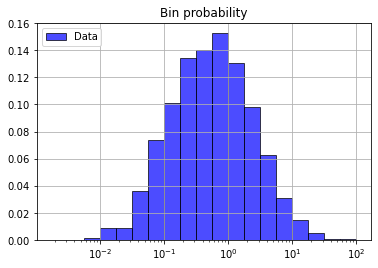

In [17]:
# statistics
# calculate point variance
histgplt_parameters = {
        # histogram limits and definition.
        'hmin' : 0, # input float (Optional: set as minimum value in dataset). Minimun value in the histogram.
        'hmax' : grid['Primary'].max(), # input float (Optional: set as maximum value in dataset). Maximum value in the histogram.
        'ncl'  : 20, # input int (Optional: set as 10). Number of bins/clases.
        'iwt'  : True, # input boolean (Optional: set True). Use weight variable?
        'ilog' : True, # input boolean (Optional: set False). If true uses log scale, otherwise uses arithmetic
        'icum' : False, # input boolean (Optional: set False). If true uses cumulative histogram, otherwise plots frequency histograms
        'va'   : grid['Primary'].values, # input rank-1 array('d') with bounds (nd). Variable
        'wt'   : grid['Primary'].values*0+1} # input rank-1 array('d') with bounds (nd) (Optional, set to array of ones). Declustering weight.

results = pygslib.gslib.histgplt(histgplt_parameters)
stats = { your_key: results[0][your_key] for your_key in ['xpt025','xlqt','xmed','xuqt','xpt975','xmin','xmax','xcvr','xmen','xvar','xfrmx','dcl'] }

In [18]:
stats 

{'xpt025': 0.06,
 'xlqt': 0.34,
 'xmed': 0.96,
 'xuqt': 2.56,
 'xpt975': 15.310013113045006,
 'xmin': 0.01,
 'xmax': 102.7,
 'xcvr': 1.9963222266705285,
 'xmen': 2.5801960000000053,
 'xvar': 26.531797841583963,
 'xfrmx': 0.15280000000000027,
 'dcl': 0.25}

Panel Variance (variogram) 7.983401769132796 0.07472976941449586
Panel Variance (experimental) 3.7777551851839997


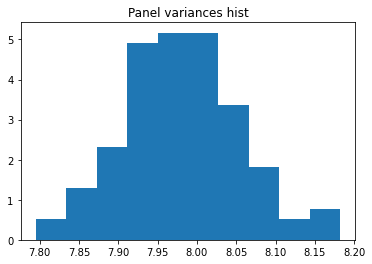

In [19]:
# Calc panel covariance using random block discretization 

# this operation is usually performed with kriging, but we do not have kriging here. 
# when kriging is available use 𝑉𝑎𝑟[𝑍(𝑉)] = 𝐶̅(𝑉, 𝑉) − krig variance + 2mu

variances = []

for i in range(100):
    
    npoints = 2000
    parameters = {
           # Coordinates of the discretization points
            'xdb'  :  np.random.uniform(0,dx_panel,size=npoints), # random point in block of 5 m
            'ydb'  :  np.random.uniform(0,dx_panel,size=npoints), # 
            'zdb'  :  np.random.uniform(0,0,size=npoints), # 
           # Variogram model from kriging parameters
            'c0'         :    variogram['c0'],   
            'it'         :   variogram['it'],  
            'cc'         :   variogram['cc'],   
            'aa'         :   variogram['aa'],    
            'aa1'        :   variogram['aa1'],     
            'aa2'        :   variogram['aa2'],    
            'ang1'       :   variogram['ang1'],     
            'ang2'       :   variogram['ang2'],    
            'ang3'       :   variogram['ang3']}

    cbb = pygslib.gslib.block_covariance(parameters)
    variances.append(cbb)

# calculate variance experimentally
exp_pvar = np.var(bmodel_panel.bmtable['Primary'])
    
# see parameters
print ('Panel Variance (variogram)', np.mean(variances), np.std(variances))
print ('Panel Variance (experimental)', exp_pvar)

pbb = 4 # 8.0 is the one from variogram

plt.hist (variances, density = True)
plt.title("Panel variances hist")
plt.show()

SMU Variance 19.99575358658298 0.12887152538601424


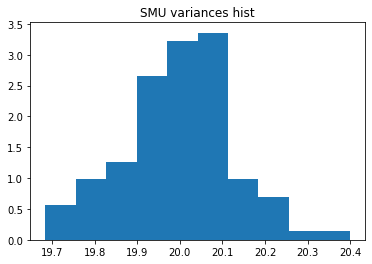

In [20]:
# Calc smu covariance using random block discretization 
variances = []

for i in range(100):
    
    npoints = 100
    parameters = {
           # Coordinates of the discretization points
            'xdb'  :  np.random.uniform(0,dx_smu,size=npoints), # random point in block of 5 m
            'ydb'  :  np.random.uniform(0,dx_smu,size=npoints), # 
            'zdb'  :  np.random.uniform(0,0,size=npoints), # 
           # Variogram model from kriging parameters
            'c0'         :    variogram['c0'],   
            'it'         :   variogram['it'],  
            'cc'         :   variogram['cc'],   
            'aa'         :   variogram['aa'],    
            'aa1'        :   variogram['aa1'],     
            'aa2'        :   variogram['aa2'],    
            'ang1'       :   variogram['ang1'],     
            'ang2'       :   variogram['ang2'],    
            'ang3'       :   variogram['ang3']}

    cbb = pygslib.gslib.block_covariance(parameters)
    variances.append(cbb)

    
# see parameters
print ('SMU Variance', np.mean(variances), np.std(variances))

cbb = 20.0

plt.hist (variances, density = True)
plt.title("SMU variances hist")
plt.show()

('zamin blk', 0.010632921714978285)
('zamax blk', 90.97968167289834)
('yamin blk', -3.297893709410522)
('yamax blk', 3.5386675683754305)
('zpmin blk', 0.010291154293310198)
('zpmax blk', 91.04127826658407)
('ypmin blk', -3.540083885192871)
('ypmax blk', 3.540083885192871)


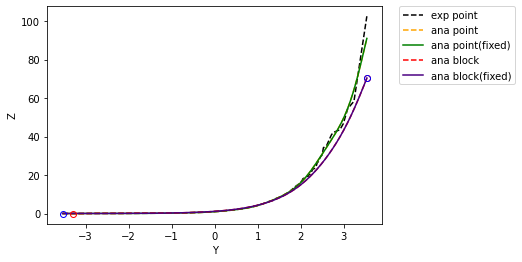

In [21]:
# change of support to smu
r = pygslib.nonlinear.get_r(Var_Zv = cbb, PCI = PCI_grid) 

# block anamorphosis
Zv, Pv, fig2, \
zamin_smu, zamax_smu, yamin_smu, yamax_smu, zpmin_smu, \
zpmax_smu, ypmin_smu, ypmax_smu = pygslib.nonlinear.anamor_blk( PCI_grid, H_grid, r = r, gauss = gauss_grid, Z = z_grid,
              ltail=1, utail=1, ltpar=1, utpar=1,
              raw=raw_grid, zana=zana_grid)

('zamin blk', 0.010293722993433174)
('zamax blk', 90.97968167289834)
('yamin blk', -3.53725125155799)
('yamax blk', 3.5386675683754305)
('zpmin blk', 0.010291154293310198)
('zpmax blk', 91.04127826658407)
('ypmin blk', -3.540083885192871)
('ypmax blk', 3.540083885192871)


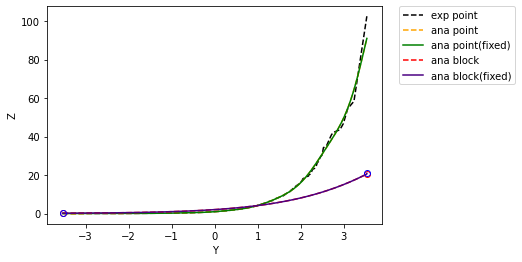

In [22]:
# change of support to panel
R = pygslib.nonlinear.get_r(Var_Zv = pbb, PCI = PCI_grid) 

# block anamorphosis
ZV, PV, fig3,\
zamin_pan, zamax_pan, yamin_pan, yamax_pan, zpmin_pan, \
zpmax_pan, ypmin_pan, ypmax_pan = pygslib.nonlinear.anamor_blk( PCI_grid, H_grid, r = R, gauss = gauss_grid, Z = z_grid,
              ltail=1, utail=1, ltpar=1, utpar=1,
              raw=raw_grid, zana=zana_grid)

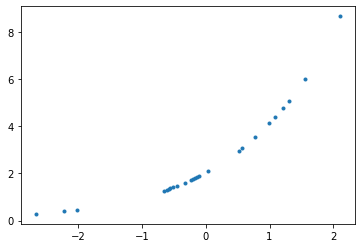

In [23]:
# get Y_panel by transforming Z_panel
Z_panel = bmodel_panel.bmtable['Primary'].values
Y_panel = pygslib.nonlinear.Z2Y_linear(z = Z_panel, 
                            zm = ZV, 
                            ym = gauss_grid, 
                            zamin = zamin_pan,
                            zamax = zamax_pan,
                            yamin = yamin_pan,
                            yamax = yamax_pan,
                            zpmin = zpmin_pan,
                            zpmax = zpmax_pan,
                            ypmin = ypmin_pan,
                            ypmax = ypmax_pan)

# check transf visually
plt.plot(Y_panel,Z_panel, '.')
plt.show()

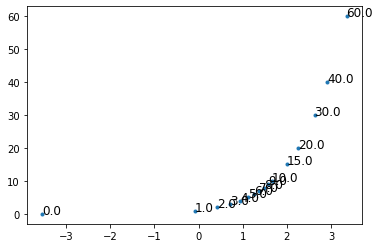

In [24]:
# Get yc_smu (gaussian version of the cutoff) from z cutoff using smu anamorposis
yc_smu = pygslib.nonlinear.Z2Y_linear(z = zc, 
                            zm = Zv, 
                            ym = gauss_grid, 
                            zamin = zamin_smu,
                            zamax = zamax_smu,
                            yamin = yamin_smu,
                            yamax = yamax_smu,
                            zpmin = zpmin_smu,
                            zpmax = zpmax_smu,
                            ypmin = ypmin_smu,
                            ypmax = ypmax_smu)

plt.plot(yc_smu,zc, '.')
for x, y in zip(yc_smu,zc):
    plt.text(x, y, str(y),  fontsize=12)
plt.show()

In [25]:
# No info effect
ro = 1

In [26]:
#calculate UC
T, Q = pygslib.nonlinear.UC(YV = Y_panel, 
                            yc = yc_smu, 
                            PCI = PCI_grid, 
                            r=r, 
                            R=R, 
                            ro=ro)

In [27]:
#Put UC estimate in the panel model and clean zero tonnage panels
for i in range(zc.shape[0]):
    bmodel_panel.bmtable['Predicted T ({})'.format(zc[i])] = T[:,i]
    bmodel_panel.bmtable['Predicted Q ({})'.format(zc[i])] = Q[:,i]
    bmodel_panel.bmtable['Predicted M ({})'.format(zc[i])] = Q[:,i]/T[:,i]
    
    #clean
    mask = (bmodel_panel.bmtable['Predicted T ({})'.format(zc[i])]>0.00001)
    
    bmodel_panel.bmtable.loc[~mask, 'Predicted T ({})'.format(zc[i])] = 0
    bmodel_panel.bmtable.loc[~mask, 'Predicted Q ({})'.format(zc[i])] = 0
    bmodel_panel.bmtable.loc[~mask, 'Predicted M ({})'.format(zc[i])] = 0



## Compare Q and T true vs estimate

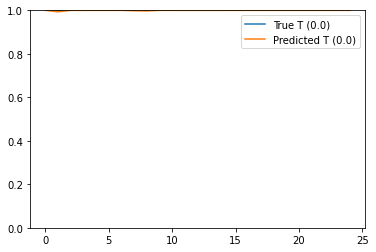

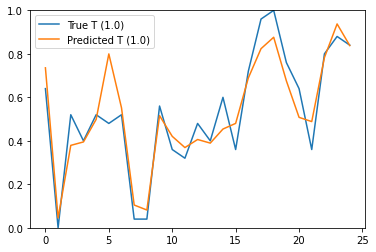

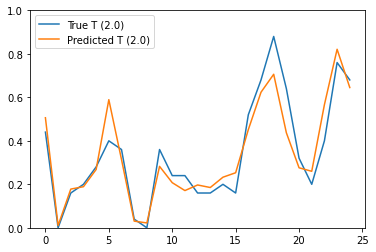

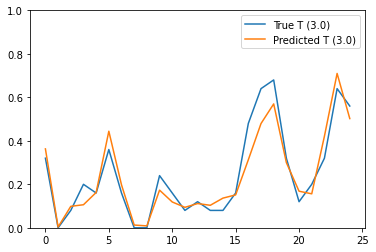

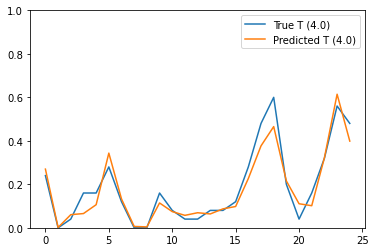

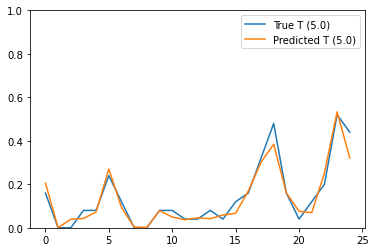

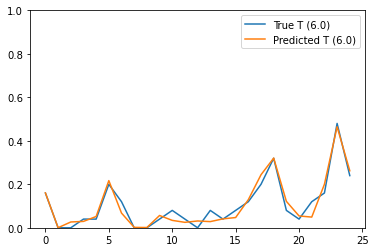

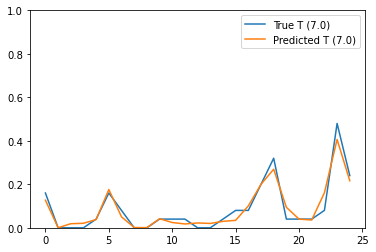

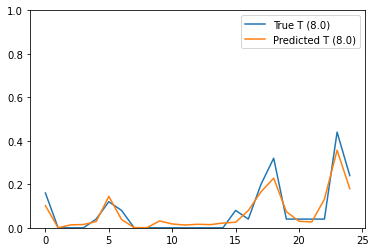

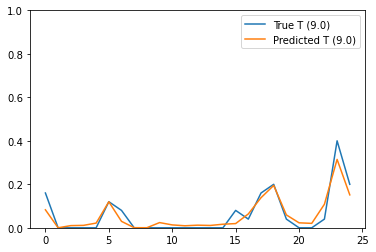

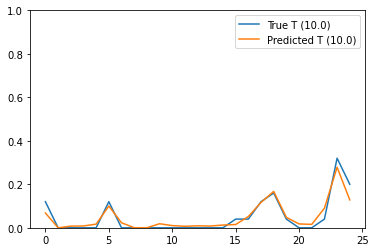

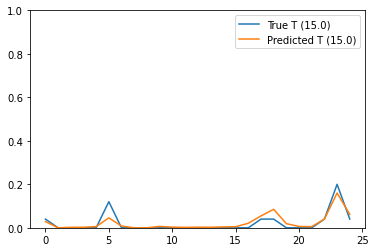

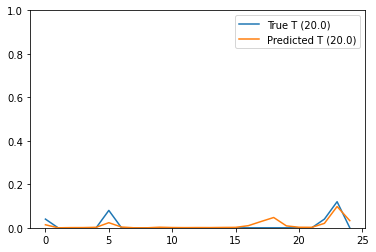

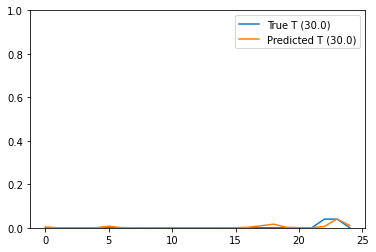

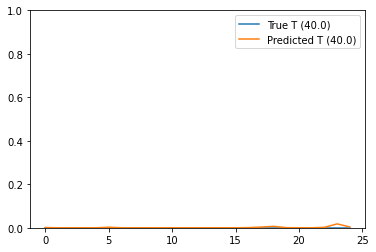

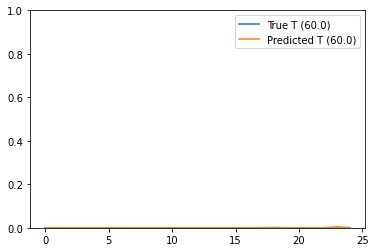

In [28]:
# compare tonnage
for c in zc:
    bmodel_panel.bmtable[['True T ({})'.format(c), 'Predicted T ({})'.format(c)]].plot(ylim=(0,1))
    plt.show()

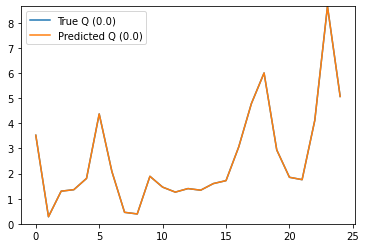

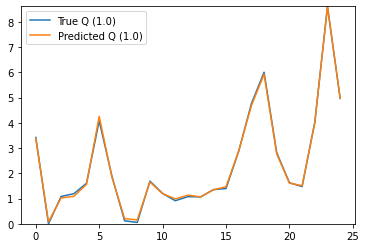

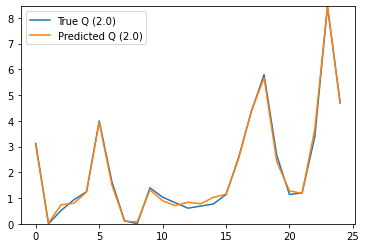

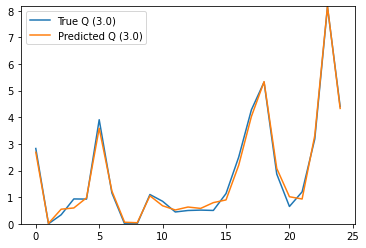

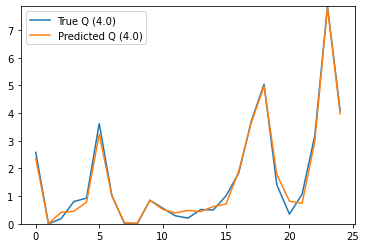

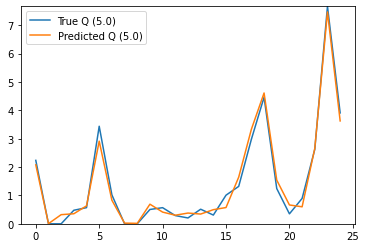

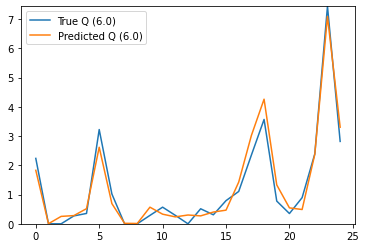

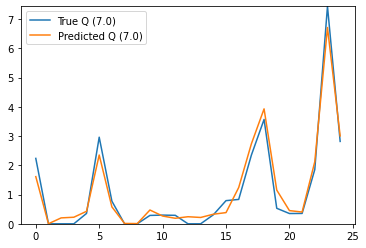

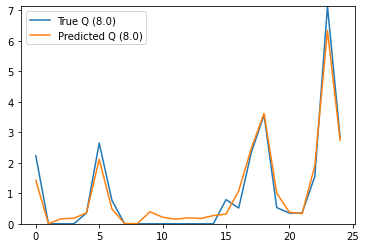

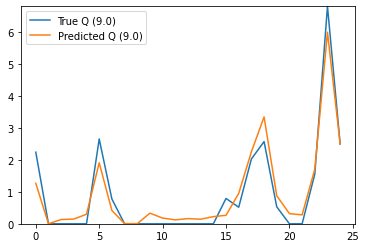

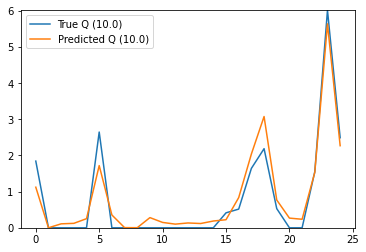

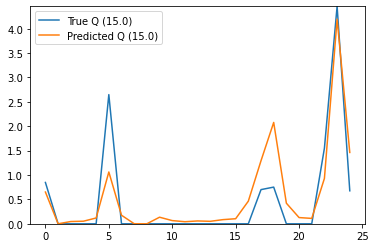

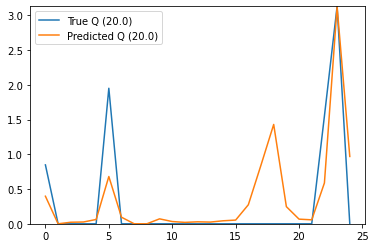

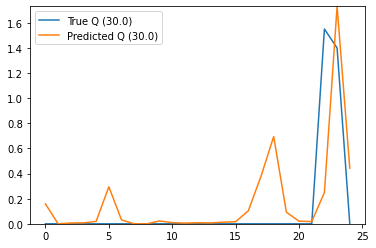

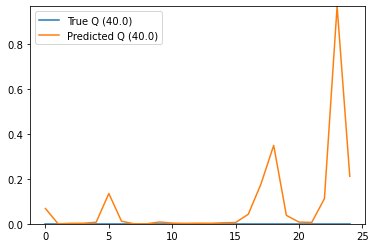

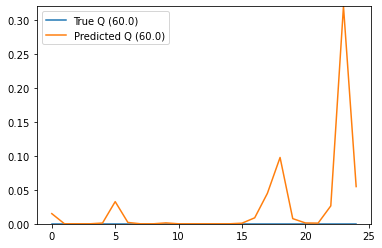

In [29]:
# compare metals
for c in zc:
    yymax = max (bmodel_panel.bmtable['True Q ({})'.format(c)].max(), bmodel_panel.bmtable['Predicted Q ({})'.format(c)].max())
    bmodel_panel.bmtable[['True Q ({})'.format(c), 'Predicted Q ({})'.format(c)]].plot(ylim=(0, yymax))
    plt.show()

# Localized UC 

In [30]:
# create a panel definition
bmodel_LUC = pygslib.blockmodel.Blockmodel(nx = 50/dx_panel, 
                                ny= 50/dx_panel, 
                                nz = 1 , 
                                xorg = 0, 
                                yorg = 0, 
                                zorg = 0, 
                                dx = dx_panel, 
                                dy = dx_panel, 
                                dz = 1)
# and set blocks 
smus = bmodel_smu.bmtable.sort_values(by = 'Primary') # need to sort for Localization
smus['IJK_smu'] = smus['IJK']                 # store IJK of smu in different variable
bmodel_LUC.set_blocks(smus)
bmodel_LUC.calc_ixyz_fromxyz(overwrite=True) # recalc panel index
bmodel_LUC.calc_ijk(overwrite=True) # recalc panel ijk
#now we have IJK panel on smu and we can filter
bmodel_LUC.bmtable.loc[bmodel_LUC.bmtable['IJK']==0]

,IJK,Primary,IX,IY,IZ,XC,YC,ZC,I (0.0),I (1.0),...,I (7.0),I (8.0),I (9.0),I (10.0),I (15.0),I (20.0),I (30.0),I (40.0),I (60.0),IJK_smu
2,0,0.1200,0,0,0,5.0,1.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,2
28,0,0.2150,0,0,0,7.0,3.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,28
27,0,0.2250,0,0,0,5.0,3.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,27
3,0,0.2275,0,0,0,7.0,1.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,3
29,0,0.2525,0,0,0,9.0,3.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,29
54,0,0.3350,0,0,0,9.0,5.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,54
4,0,0.4075,0,0,0,9.0,1.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,4
53,0,0.4200,0,0,0,7.0,5.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,53
79,0,0.4250,0,0,0,9.0,7.0,0.5,1,0,...,0,0,0,0,0,0,0,0,0,79
103,0,1.1800,0,0,0,7.0,9.0,0.5,1,1,...,0,0,0,0,0,0,0,0,0,103


In [31]:
#ready to loop and localize using metal and grade
t_names = ['Predicted T ({})'.format(str(c).strip()) for c in zc]
q_names = ['Predicted Q ({})'.format(str(c).strip()) for c in zc]
m_names = ['Predicted M ({})'.format(str(c).strip()) for c in zc]


bmodel_LUC.bmtable['LUC_m'] = np.nan
bmodel_LUC.bmtable['LUC_g'] = np.nan

for i in bmodel_LUC.bmtable['IJK'].unique():
    print ('localizing', i)
    
    T = bmodel_panel.bmtable.loc[bmodel_panel.bmtable['IJK'] ==i, t_names].values.ravel()
    Q = bmodel_panel.bmtable.loc[bmodel_panel.bmtable['IJK'] ==i, q_names].values.ravel()
    M = bmodel_panel.bmtable.loc[bmodel_panel.bmtable['IJK'] ==i, m_names].values.ravel()
    
    n = bmodel_LUC.bmtable.loc[bmodel_LUC.bmtable['IJK'] ==i].shape[0]
    
    mm, tt, qq = pygslib.nonlinear.localization_on_metal(T,Q,n)
    mm2 = pygslib.nonlinear.localization_on_grade(n+1, T, M, zc)
    
    bmodel_LUC.bmtable.loc[bmodel_LUC.bmtable['IJK']==i, 'LUC_m'] = mm
    bmodel_LUC.bmtable.loc[bmodel_LUC.bmtable['IJK']==i, 'LUC_g'] = mm2

localizing 1
localizing 8
localizing 11
localizing 21
localizing 6
localizing 7
localizing 2
localizing 3
localizing 10
localizing 9
localizing 4
localizing 13
localizing 15
localizing 0
localizing 22
localizing 5
localizing 16
localizing 12
localizing 20
localizing 19
localizing 23
localizing 24
localizing 14
localizing 17
localizing 18


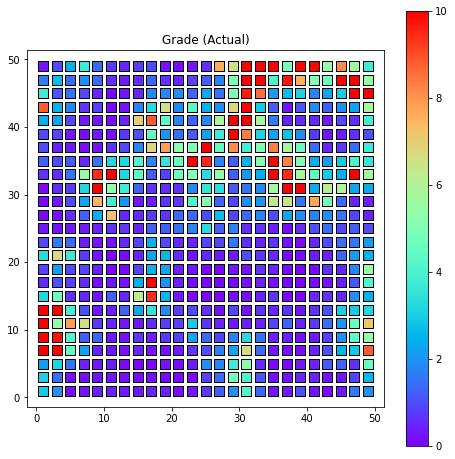

In [32]:
# see results
# plot the grade using matplotlib
plt.figure(figsize = (8,8))

plt.scatter(bmodel_smu.bmtable['XC'],bmodel_smu.bmtable['YC'], 
            c= bmodel_smu.bmtable['Primary'], 
            marker="s", cmap = 'rainbow', alpha=1, s = 100, edgecolors='k', vmin=0, vmax=10)
plt.axis('scaled')
plt.colorbar()
plt.title("Grade (Actual)")
plt.show()

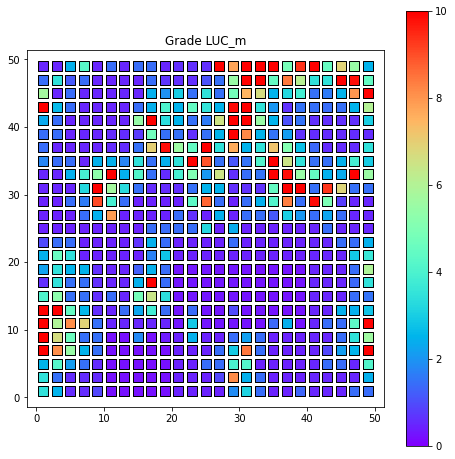

In [33]:
# see results
# plot the grade using matplotlib
plt.figure(figsize = (8,8))

plt.scatter(bmodel_LUC.bmtable['XC'],bmodel_LUC.bmtable['YC'], 
            c= bmodel_LUC.bmtable['LUC_m'], 
            marker="s", cmap = 'rainbow', alpha=1, s = 100, edgecolors='k', vmin=0, vmax=10)
plt.axis('scaled')
plt.colorbar()
plt.title("Grade LUC_m")
plt.show()

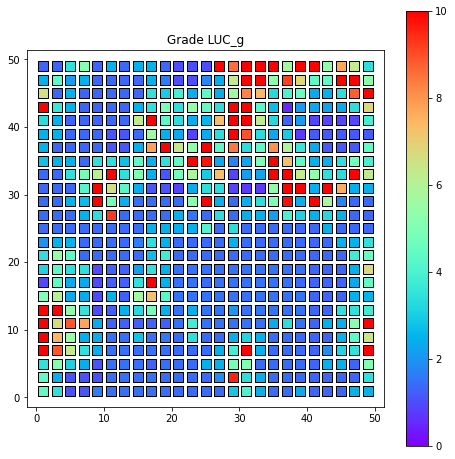

In [34]:
# see results
# plot the grade using matplotlib
plt.figure(figsize = (8,8))

plt.scatter(bmodel_LUC.bmtable['XC'],bmodel_LUC.bmtable['YC'], 
            c= bmodel_LUC.bmtable['LUC_g'], 
            marker="s", cmap = 'rainbow', alpha=1, s = 100, edgecolors='k', vmin=0, vmax=10)
plt.axis('scaled')
plt.colorbar()
plt.title("Grade LUC_g")
plt.show()

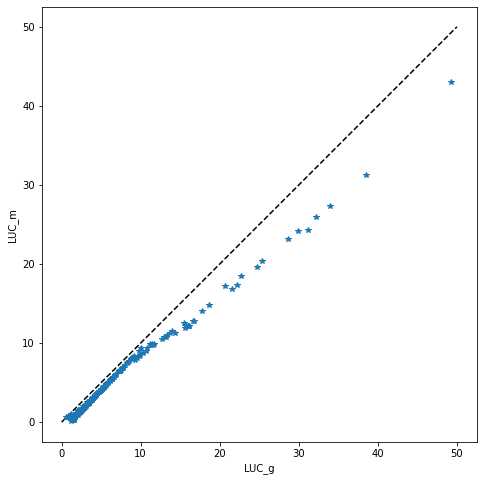

In [35]:
# compare the two localization tools
plt.figure(figsize = (8,8))
plt.plot([0, 50],[0, 50], '--k')
plt.plot(bmodel_LUC.bmtable['LUC_g'], bmodel_LUC.bmtable['LUC_m'], '*')
plt.xlabel('LUC_g')
plt.ylabel('LUC_m')
plt.axis('scaled');

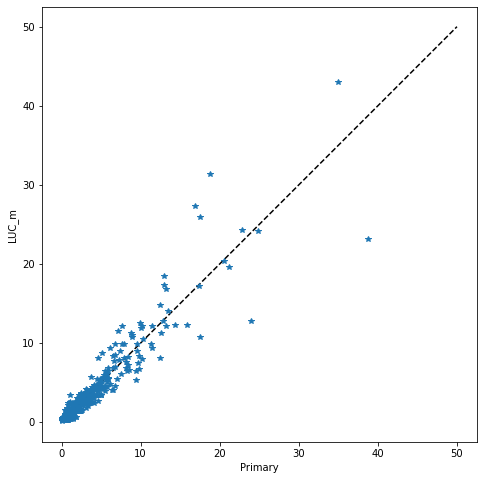

In [36]:
# compare the two localization tools
plt.figure(figsize = (8,8))
plt.plot([0, 50],[0, 50], '--k')
plt.plot(bmodel_LUC.bmtable['Primary'], bmodel_LUC.bmtable['LUC_m'], '*')
plt.xlabel('Primary')
plt.ylabel('LUC_m')
plt.axis('scaled');

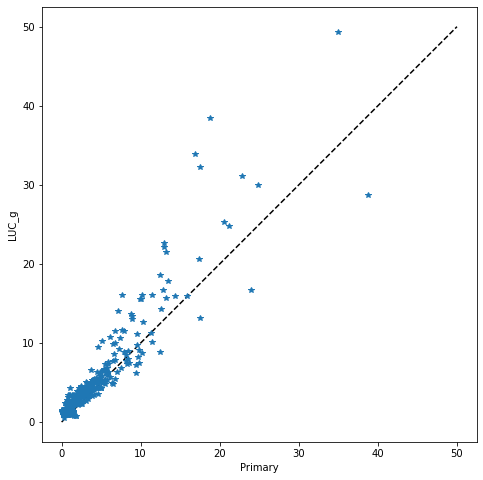

In [37]:
# compare the two localization tools
plt.figure(figsize = (8,8))
plt.plot([0, 50],[0, 50], '--k')
plt.plot(bmodel_LUC.bmtable['Primary'], bmodel_LUC.bmtable['LUC_g'], '*')
plt.xlabel('Primary')
plt.ylabel('LUC_g')
plt.axis('scaled');